# 1. Data Load

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## 1.1 Charging Stations

In [2]:
# load charging station data from opendata portal of Rhein-Kreis-Neuss found via govdata.de
# skip bad lines
stations_raw = pd.read_csv("https://opendata.rhein-kreis-neuss.de/explore/dataset/rhein-kreis-neuss-ladesaulen-in-deutschland/download/?format=csv",
                           on_bad_lines = "skip",
                           sep = ";",
                           dtype = {"betreiber": str,
                                    "anzahl_ladepunkte": int,
                                    "anschlussleistung": float,
                                    "steckertypen1": str,
                                    "steckertypen2": str,
                                    "steckertypen3": str,
                                    "steckertypen4": str,
                                    "p1_kw": float,
                                    "p2_kw": float,
                                    "p3_kw": float,
                                    "p4_kw": float,
                                    "kreis_kreisfreie_stadt": str,
                                    "ort": str,
                                    "postleitzahl": str,
                                    "strasse": str,
                                    "hausnummer": str,
                                    "adresszusatz": str,
                                    "koordinaten": str,
                                    "normalladeeinrichtung": str},
                           parse_dates = ["inbetriebnahmedatum"])

## 1.2 Registered Vehicles

In [3]:
# load vehicle registration data from opendata portal from Kraftfahrtbundesamt
vehicles_raw = pd.read_excel("https://www.kba.de/SharedDocs/Downloads/DE/Statistik/Fahrzeuge/FZ3/fz3_2022.xlsx?__blob=publicationFile&v=3", sheet_name = "FZ 3.1")

## 1.3 Mapping Data: PLZ to Administrative Region

In [4]:
# load mapping data linking PLZ and Administrative Region
mapping_raw = pd.read_csv("https://downloads.suche-postleitzahl.org/v2/public/zuordnung_plz_ort.csv",
                          sep = ",",
                          dtype = {"osm_id": str,
                                   "ags": str,
                                   "ort": str,
                                   "plz": str,
                                   "landkreis": str,
                                   "bundesland": str})

# 2. Data Cleaning

## 2.1Charging Stations

In [5]:
# copy raw data to working df
stations = stations_raw.copy()

# replace column names with english names
stations.columns = ["owner",
                    "count",
                    "connected_load",
                    "connector_1",
                    "connector_2",
                    "connector_3",
                    "connector_4",
                    "p1",
                    "p2",
                    "p3",
                    "p4",
                    "district",
                    "municipality",
                    "zip",
                    "street_name",
                    "street_number",
                    "additional_address",
                    "installation_date",
                    "coordinates",
                    "type"]

# split coordinates into separate columns
stations[["latitude", "longitude"]] = stations.coordinates.str.split(",", expand = True)

# remove irrelevant columns
stations = stations.drop(["owner", "connected_load", "connector_1", "connector_2", "connector_3", "connector_4", "p1", "p2", "p3", "p4", "district", "additional_address", "coordinates"], axis = 1)

# summarise data into stations_summary
stations_summary = stations.groupby("zip").agg({"count": "sum"})

# convert index to column
stations_summary["zip"] = stations_summary.index

#rename and reset index
stations_summary.index.names = ["index"]
stations_summary = stations_summary.reset_index(drop = True)

## 2.2 Registered Vehicles

In [6]:
# copy raw data to working df
vehicles = vehicles_raw.copy()

# remove empty first column
vehicles.drop(vehicles.columns[0], axis = 1, inplace = True)

# drop first rows containing no usable data
vehicles.drop(vehicles.index[0:8], axis = 0, inplace = True)

# drop last rows containing no usable data
vehicles.drop([11209, 11210, 11211, 11212, 11213, 11214, 11215 ,11216, 11217, 11218, 11219],
              axis = "index",
              inplace = True)

# reset index
vehicles.reset_index(drop = True, inplace = True)

# assign proper column names
vehicles.columns = ["state",
                    "district_raw",
                    "municipality",
                    "motorcycles",
                    "cars_total",
                    "cars_business",
                    "trucks",
                    "tractors_total",
                    "tractors_agri_forest",
                    "other_vehicles_buses",
                    "vehicles_total",
                    "trailers"]

# drop irrelevant columns
vehicles.drop(["motorcycles",
               "cars_business",
               "trucks",
               "tractors_total",
               "tractors_agri_forest",
               "other_vehicles_buses",
               "vehicles_total",
               "trailers" ],
              axis = 1,
              inplace = True)

# fill NaN values
# replace in these columns
for column in ["state", "district_raw"]:
    # loop through all the rows
    for row in range(0,len(vehicles)):
        # check if value is NaN
        if vehicles.iloc[row][column] != vehicles.iloc[row][column]:
            # replace with value from previous row if NaN
            vehicles.iloc[row][column] = vehicles.iloc[row-1][column]

# remove summary rows
# create list to store row indexes to be dropped
drop = []

# search in municipality column
column = "municipality"

# loop through all the rows
for row in range(0, len(vehicles)):
    # check if row is summary row
    if vehicles.iloc[row][column] == "ZUSAMMEN":
        # append to list to be dropped later
        drop.append(row)

# search in state column
column = "state"
# loop through all the rows
for row in range(0, len(vehicles)):
    # check if row is summary row
    if "INSGESAMT" in vehicles.iloc[row][column]:
        # append to list to be dropped later
        drop.append(row)

# iterate through droppable list and execute drop
for row in drop:
    vehicles.drop([row], axis = "index", inplace = True)

# reset index
vehicles.reset_index(drop = True, inplace = True)

# fix values mismatching shape file (Trier & Eisenach)
vehicles.loc[vehicles["municipality"] == "54290  TRIER,ST.", "district_raw"] = "TRIER (07235)"
vehicles.loc[vehicles["municipality"] == "99817  Eisenach, Stadt", "district_raw"] = "EISENACH (16056)"

# extract district id
vehicles["district_id"] = vehicles["district_raw"].str[-8:].str[2:7]

#extract district name
vehicles["district"] = vehicles["district_raw"].str[:-8]

# drop irrelevant columns
vehicles.drop(["state",
               "municipality",
               "district_raw",
               "district"],
              axis = 1,
              inplace = True)

# reorder columns
vehicles = vehicles[["district_id", "cars_total"]]

# replace "." & "-" value with 0
vehicles.loc[vehicles["cars_total"] == ".", "cars_total"] = 0
vehicles.loc[vehicles["cars_total"] == "-", "cars_total"] = 0

# assign correct column types
vehicles = vehicles.astype({"district_id": str, "cars_total": int})

# summarize amount of cars per district_id
vehicles = vehicles.groupby("district_id").agg({"cars_total": "sum"})

# convert index to column
vehicles["district_id"] = vehicles.index

#rename and reset index
vehicles.index.names = ["index"]
vehicles = vehicles.reset_index(drop = True)

vehicles.to_clipboard()

## 2.3 Mapping Data: PLZ to Administrative Region

In [7]:
# copy raw data to working df
mapping = mapping_raw.copy()

# assign proper column names
mapping.columns =["osm_id","district_id","city","zip","district","state"]

# fix values mismatching shape file (Eisenach)
mapping.loc[mapping["zip"] == "99817", "district_id"] = "16056000"

# fill district column with city name if empty
for row in range(0, len(mapping)):
    # check if district column is empty
    if mapping.iloc[row]["district_id"] != mapping.iloc[row]["district_id"]:
        # insert city name
        mapping.iloc[row]["district_id"] = mapping.iloc[row]["city"]

# drop irrelevant columns
mapping.drop(["osm_id", "city"], axis = 1, inplace = True)

# strip last 3 digits of ags code
mapping["district_id"] = mapping["district_id"].str[:-3]

# remove duplicates created by truncation of district_id
mapping.drop_duplicates(inplace = True)

# 3. Data Merge

In [8]:
# join mapping data with stations_summary
result = pd.merge(mapping, stations_summary, on = "zip", how = "left")

# summarise on district level
result = result.groupby(["district_id"]).agg({"count": "sum"})

# join with vehicle data
result = pd.merge(result, vehicles, on = "district_id", how = "left")

# 4. KPI Computation

In [9]:
# calculate amount of stations per 1000 cars per district
result["stations_per_1000_cars"] = round(result["count"]/(result["cars_total"]/1000),2)

# 5. Visualization

## 5.1 Visualization Preparation

In [10]:
# read geojson file containing district shapes
districts = gpd.read_file("data/districts.json")

# fix values mismatching vehicle & station data (Göttingen & Osterode am Harz)
districts.loc[districts["cca_2"] == "03152", "cca_2"] = "03159"
districts.loc[districts["cca_2"] == "03156", "cca_2"] = "03159"

# add KPI to districts dataframe
districts = pd.merge(districts, result, left_on = "cca_2", right_on = "district_id", how = "left")

## 5.2 Visualization Creation

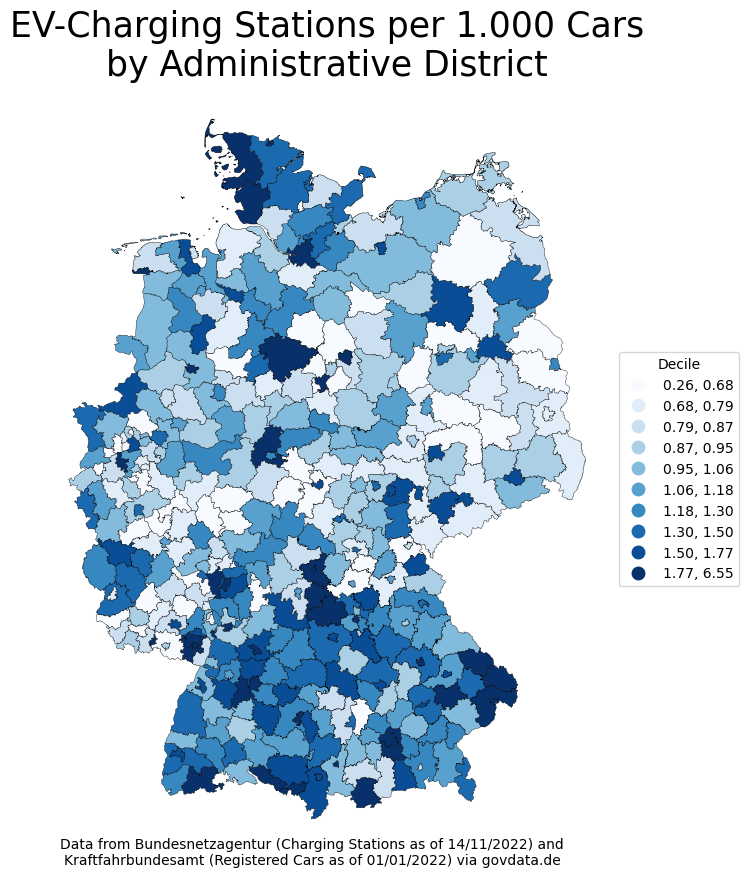

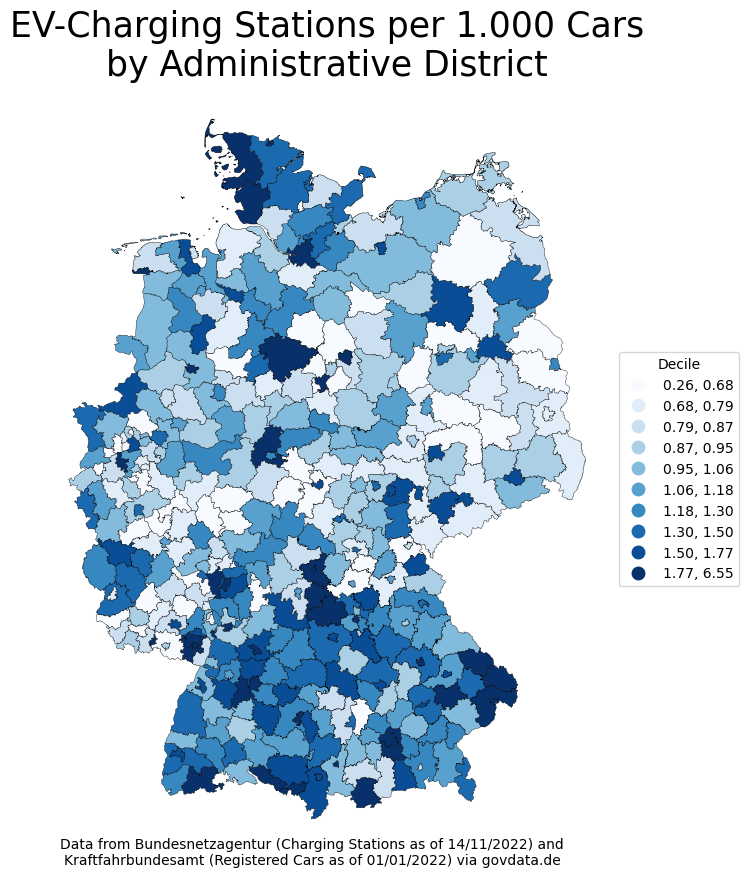

In [12]:
# define chart configuration
fig, ax = plt.subplots(figsize = (12, 10), subplot_kw = dict(aspect = "equal"))

# add plot
districts.plot(column = "stations_per_1000_cars",
               ax = ax,
               # apply calssificatino scheme
               scheme = "quantiles",
               # apply split into 10 buckets to classification
               k = 10,
               # select color schema
               cmap = "Blues",
               # set legend to "on"
               legend = True,
               # configure legend
               legend_kwds = {'loc': 'center left',
                              "title": "Decile",
                              'bbox_to_anchor':(1, 0.5)},
               # configure polygon border lines
               edgecolor = "black",
               linewidth = 0.25)

# remove gridlines
plt.axis('off')
# add title
plt.title("EV-Charging Stations per 1.000 Cars\nby Administrative District", fontdict = {"fontsize": 25})

# reposition caption
plt.figtext(0.5, 0.1, "Data from Bundesnetzagentur (Charging Stations as of 14/11/2022) and\nKraftfahrbundesamt (Registered Cars as of 01/01/2022) via govdata.de", horizontalalignment = 'center', fontsize = 10)

# generate visualization
fig